# CSC_52081_EP_TP2

## Introduction

File may be found in: [https://www.lix.polytechnique.fr/~jread](https://www.lix.polytechnique.fr/~jread/courses/inf581/labs/01/).

### Main Objectives

Intelligent decision making involves several components. In the context of a low-dimensional and synthetic toy:

- **perception**: observation;
- **knowledge**: representation;
- **reasoning**: inference;
- **acting**: decision-making;

The objective is to design a rational / intelligent agent with:
- *learning*;
- *scalability*;

### Imports

Make sure the `environment.py` is in your working directory.

In [2]:
# if you are using Google Colab, uncomment the following line (comment again when you have run it)
# !wget https://www.lix.polytechnique.fr/~jread/courses/inf581/labs/01/environment.py

from environment import Environment
from extracter import extract_tagged_cells

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


extract_tagged_cells(
    "CSC_52081_EP_TP1.ipynb",
    "agent.py",
    tags=["import numpy as np", "def generate_trajectory", "class Agent"]
)

from agent import Agent, generate_trajectory

['import numpy as np', 'def generate_trajectory', 'class Agent']
An error occurred: [Errno 2] No such file or directory: 'CSC_52081_EP_TP1.ipynb'


## Environment

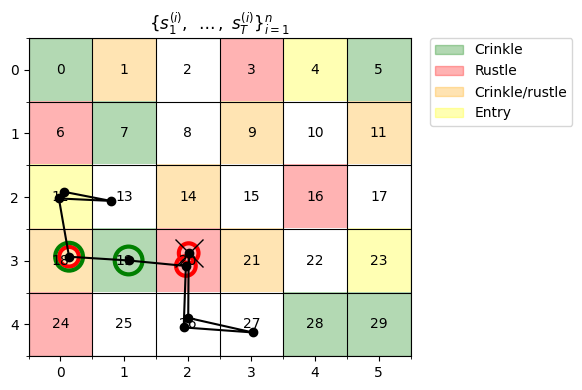

In [3]:
# grid position colors
#   1: crinkle
#   2: rustle
#   3: crinkle and rustle
#   4: entry

grid: np.ndarray[float] = np.array([
    [1, 3, 0, 2, 4, 1],
    [2, 1, 0, 3, 0, 3],
    [4, 0, 3, 0, 2, 0],
    [3, 1, 2, 3, 0, 4],
    [2, 0, 0, 0, 1, 1]
])

env: Environment = Environment(grid)
observations, states = generate_trajectory(env, 10)

fig, ax = env.render(states, observations, title=r"$\{s^{(i)}_1,\;\dots,\;s^{(i)}_T\}_{i=1}^n$")
plt.show()


## Part I. `agent.P_trajectories(M>0)`

### Theory

In this case, we have modified the `Environment` class in `environment.py` to produce more dense trees by allowing False-Positives sound emissions.

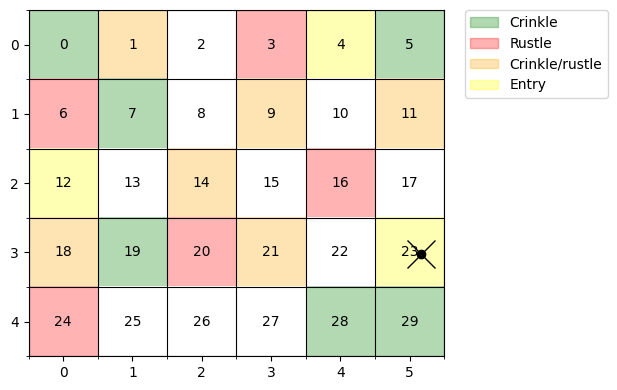

In [4]:
env: Environment = Environment(grid, fps=True)   # False Positives

states, observations = env.step()
states: np.ndarray[float] = np.array([states]).reshape(1,-1)
observations: np.ndarray[float] = np.array([observations])

fig, ax = env.render(states, observations)
plt.show()

#### Monte Carlo Search

Essentially, you should sample `M` trajectories as an approximation:
$$
    \{s^{(m)}_1,\ldots,s^{(m)}_T, p^{(m)}\}_{m=1}^M \approx P(S_1,\ldots,S_T \mid \vec{x}_1,\ldots,\vec{x}_T)
$$

You can use what is known as **ancestral sampling**, since you have access to the environment, sample $s_1 \sim P(s_1 | \vec{x}_1)$, then $s_2 \sim P(s_2 | s_1)$ and so on.

Again, this is not the same as simply using `generate_trajectory()`, because we are conditioning on the observation $\vec{x}_1,\ldots,\vec{x}_T$. 

### Question

Reimplement `agent.P_trajectories` where it should use your solution from last week when `M<0` and take `M` samples when `M>0`.

What happens if we only made a longer trajectory, but it was still sparse in probabilities? Would *ancestral sampling* still be appropriate?

### Answer

With longer trajectories it would be more likely for the Monte Carlo Search using Ancestral Sampling to consider trajectories not suited for the problem lending to an overall worse estimation of the agent's action.

In this case, Ancestral Sampling would not be a suited method for the problem.

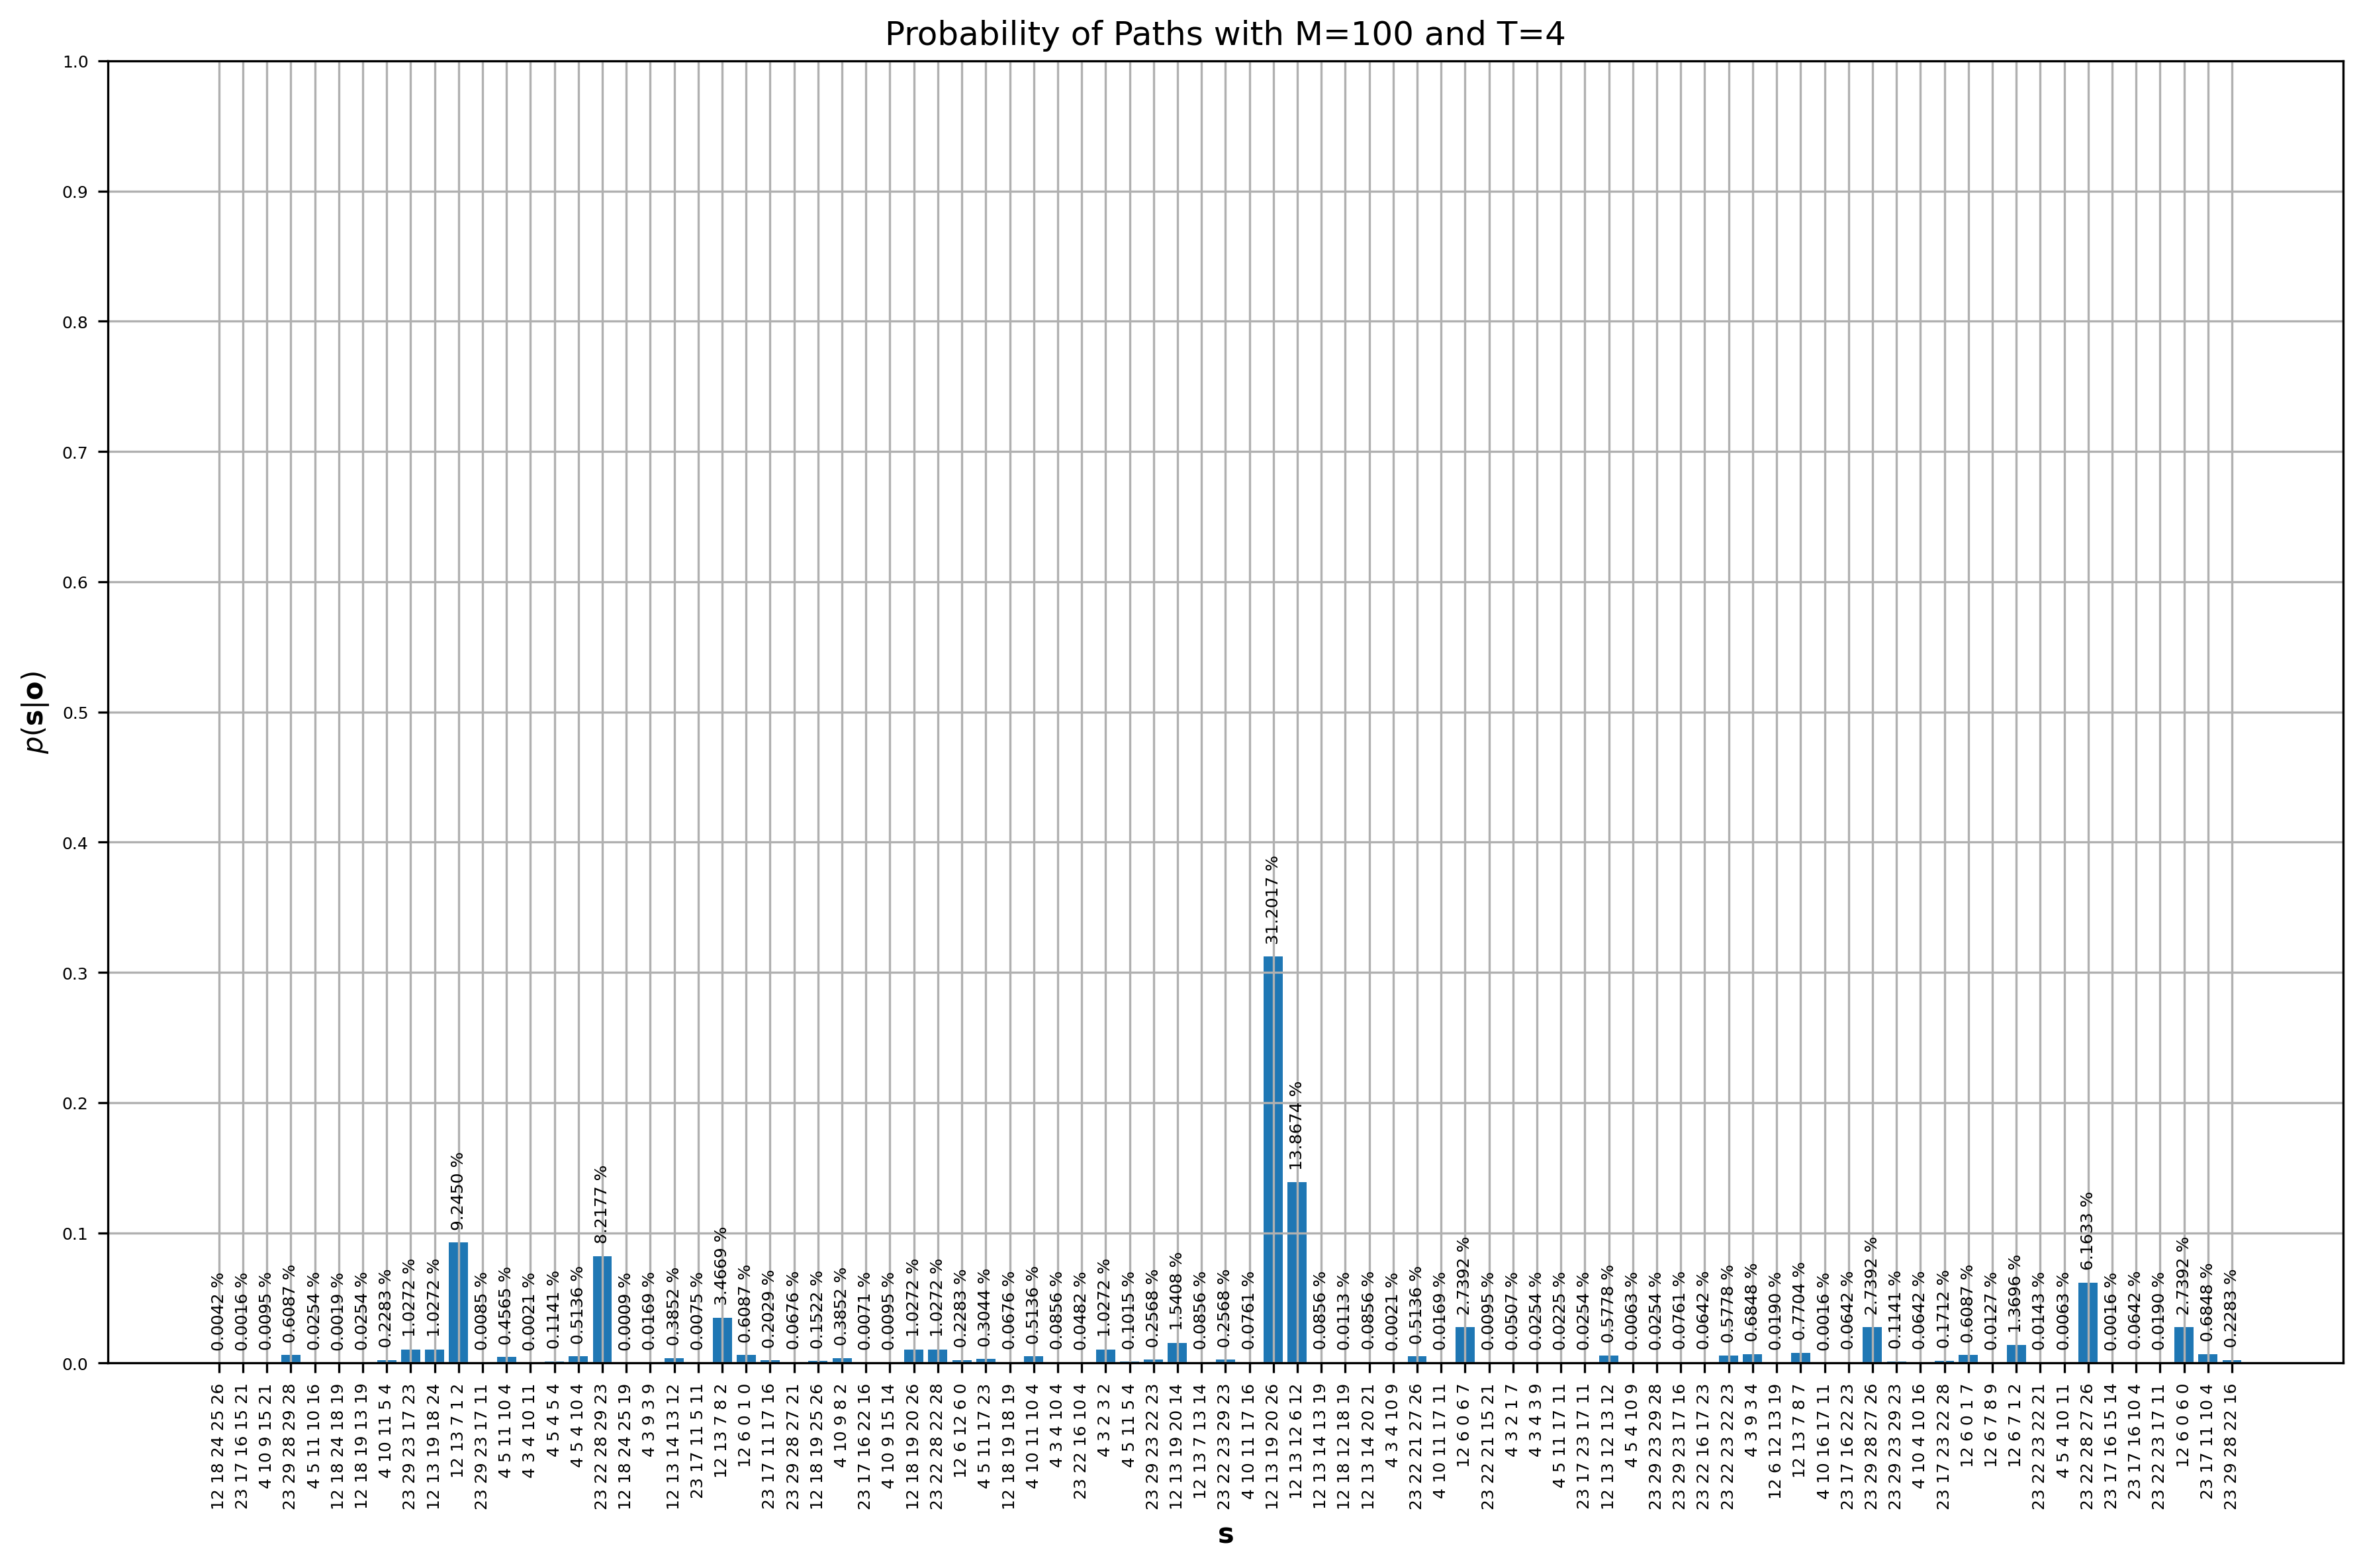

In [5]:
trajectory_length: int = 4
monte_calor_constant: int = 100

agent = Agent(env)
observations, states = generate_trajectory(env, trajectory_length)
P_trajectories = agent.P_trajectories(observations, M=monte_calor_constant)


plt.figure(figsize=(12, 8), dpi=300)

bars = plt.bar(list(P_trajectories.keys()), list(P_trajectories.values()))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
             f'{height*100:.4f} %',
             ha='center', va='bottom', rotation=90, fontsize=6)

plt.title(f"Probability of Paths with M={monte_calor_constant} and T={trajectory_length}")
plt.xlabel(r"$\mathbf{s}$")
plt.xticks(rotation=90, ha='center')
plt.ylabel(r"$p(\mathbf{s}|\mathbf{o})$")
plt.ylim([0, 1.0])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid()
plt.tick_params(labelsize=6)
plt.tight_layout()

plt.show()

## Part II. `torch.nn.TinyTransformerDecoder`

Until now we supposed full unfettered access to the environment. But now suppose that we do *not* have access to the environment definition. Rather, we need to learn it.

In [6]:
env = Environment(grid, fps=False)

### Theory

Suppose that we *do* have access to trajectories from the environment, generated by some agent:
$$
    \mathbf{o}_1,\ldots,\mathbf{o}_T \sim p
    \qquad\text{and}\qquad
    \mathbf{a} \sim \pi(\mathbf{o}_1,\ldots,\mathbf{o}_T)
$$

Where $\mathbf{a}$ is a one-hot-encoded action, relating to the number of possible actions.

#### Generating Data

First, it is necessary to generate a dataset to be used in the machine learning model as represented by the following equation:
$$
    D_{i\in[0,\;n]} = \{(\mathbf{o}_{1:T}, \mathbf{a}_i)\}
$$

Where the dataset $D$ will contain $n$ tuples, each containing $T\times 2$ sound observations and $T\times \text{n\_states}$ actions.

#### Transformers

We will be using transformers, which are excellent for sequential modelling. Have a look at the following `class`, which we will use in the following. 

In [7]:
class TinyTransformerDecoder(nn.Module):
    def __init__(
            self,
            input_dim: int,
            output_dim: int,
            embedding_dim: int = 16,
            num_layers: int = 1,
            num_heads: int = 1,
            max_seq_len: int = 500
        ):
        super(TinyTransformerDecoder, self).__init__()

        self.input_projection = nn.Linear(
            input_dim, embedding_dim
        )

        self.positional_encoding = self._generate_positional_encoding(
            max_seq_len, embedding_dim
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model = embedding_dim,
            nhead = num_heads,
            dim_feedforward = 2 * embedding_dim,
            dropout = 0.0,
            batch_first = True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        self.output_projection = nn.Linear(embedding_dim, output_dim)


    def _generate_positional_encoding(self, max_seq_len: int, embedding_dim: int) -> torch.Tensor:
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim)
        )
        pos_encoding = torch.zeros(max_seq_len, embedding_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)

        return pos_encoding  # Shape: (max_seq_len, embedding_dim)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (batch_size, seq_len, input_dim)
        x_emb = self.input_projection(x)

        # Add positional encoding
        pos_encoding = self.positional_encoding[:x.size(1), :].to(x.device)
        x_emb = x_emb + pos_encoding

        # Generate causal mask
        causal_mask = nn.Transformer.generate_square_subsequent_mask(x.size(1))

        # Use mask in the encoder
        x_transformed = self.transformer(x_emb, mask=causal_mask)

        output = self.output_projection(x_transformed)
        return output

## Part III. `torch.nn.TinyTransformerDecoder`, Imitation Learning

### Theory

Imitation learning is an alternative to reinforcement learning, for producing an autonomous agent. Rather than learn via reinforcement, we can learn to imitate an expert agent that has already solved a given task. In this case, we would suppose that the agent which has generated the trajectories in data set `D` is such an expert. Specifically, in imitation learning:
$$
    \mathbf{a}_t = \pi(\mathbf{o}_1, \ldots, \mathbf{o}_t)
$$

Where $\pi$ the policy of the agent, that maps inputs to an action.

#### Questions

Use the `TinyTransformerDecoder` defined above to complete the Imitation Learning task in the cell below.

**Important** Do not remove the first comment from the cell `# TASK 2 IMITATION LEARNING` as it will help us locate your implementation. 

**Important** Your configuration should complete in less than 5 minutes on a personal laptop machine (noting that 2 minutes should be more than enough)

In the case of the Environment studied in Lab 01, is it clear why we should consider the full history of observations?

#### Answer

In the case of Imitation Learning the full history of observations is necessary because only then the model will be able to predict correctly the model. Features such as entry points can only be learned with the hole path otherwise the model wouldn't start from the correct position and therefore return incorrect path estimations.

In [8]:
def create_dataset(N: int = 1000, T: int = 6) -> list[torch.Tensor]:
    '''
    Return a dataset D containing N tuples of T observations and respective actions.

    Parameters
    ----------

        N (int, optional): number of examples on the dataset. Default is '1000'.
        T (int, optional): number of observations per example. Default is '6'.
    '''
    D = []

    for _ in range(N):
        observations, states = generate_trajectory(env, T)
        observations = torch.tensor(observations, dtype = torch.float)
        states = torch.tensor(states)

        states_one_hot = torch.nn.functional.one_hot(states, num_classes=env.n_states)
        D.append((observations, states_one_hot.float()))

    return D

D = create_dataset()

In [9]:
from torch.utils.data import DataLoader, TensorDataset


def generate_imitation_data(
        N: int = 50000, batch_size: int = 32, train_split: float = 0.8
    ) -> list[torch.Tensor, torch.Tensor]:
    """
    Generate Imitation Learning Model data.

    Parameters:
    -----------

        N (int, optional): number of examples on the dataset. Default is '1000'.
        batch_size (int, optional) : data batch size. Default is '32'.
        train_split (float, optional) : percentage of data for training. Default is '0.8'.
    """
    D = create_dataset(N)
    train, validation = torch.utils.data.random_split(D, [train_split, 1 - train_split])

    data: list = []

    for dataset in [train, validation]:
        observations = torch.stack([observations for observations, _ in dataset])
        states = torch.stack([states for _, states in dataset])

        dataloader = DataLoader(
            TensorDataset(observations, states), batch_size = batch_size, shuffle=True
        )

        data.append(dataloader)

    return data

In [10]:
# TASK 2 IMITATION LEARNING

train_dataloader, _ = generate_imitation_data()


# Model Initialization
model = TinyTransformerDecoder(
    input_dim = 2,
    output_dim = env.n_states,
    embedding_dim = 64,
    num_layers = 3,
    num_heads = 4,
    max_seq_len = 10
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


model.train()
for epoch in range(50):
    for observed_batch, target_batch in train_dataloader:
        target_batch = target_batch.argmax(dim=-1)

        predictions = model(observed_batch)

        optimizer.zero_grad()
        loss = criterion(predictions.view(-1, predictions.size(-1)), target_batch.view(-1))
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1:02d}, Loss: {loss.item()}")


Epoch 1, Loss: 1.1333342790603638
Epoch 2, Loss: 1.4093765020370483
Epoch 3, Loss: 1.338804841041565
Epoch 4, Loss: 0.9724851250648499
Epoch 5, Loss: 1.235367774963379
Epoch 6, Loss: 1.1078810691833496
Epoch 7, Loss: 1.1833463907241821
Epoch 8, Loss: 2.005969762802124
Epoch 9, Loss: 1.0169810056686401
Epoch 10, Loss: 1.2243900299072266
Epoch 11, Loss: 0.5299785733222961
Epoch 12, Loss: 1.17396080493927
Epoch 13, Loss: 1.9753756523132324
Epoch 14, Loss: 0.5116510987281799
Epoch 15, Loss: 1.6438794136047363
Epoch 16, Loss: 1.7980860471725464
Epoch 17, Loss: 1.0002427101135254
Epoch 18, Loss: 0.6595787405967712
Epoch 19, Loss: 0.71133953332901
Epoch 20, Loss: 0.5766285061836243
Epoch 21, Loss: 1.3836950063705444
Epoch 22, Loss: 0.4795205891132355
Epoch 23, Loss: 0.8322871327400208
Epoch 24, Loss: 0.7473242282867432
Epoch 25, Loss: 1.0850944519042969
Epoch 26, Loss: 1.0262365341186523
Epoch 27, Loss: 0.6827406883239746
Epoch 28, Loss: 1.1661847829818726
Epoch 29, Loss: 1.2010992765426636
E

### Evaluation

In the following, we deploy the agent and test it, in a similar way to Lab 01. First, we wrap the model inference in the `act` function of the `DTAgent` class so we can compare.

#### Question

How well is our imitation model performing?

#### Answer

In [11]:
class DTAgent:

    def act(self, observation: np.ndarray[float]) -> int:
        '''
        Decide on the best action to take, under the provided observation. 

        Parameters
        ----------

        ooo : array_like(int,ndim=2)
            t observations (of 2 bits each)

        Returns
        -------

        a : int
            the chosen action a, it should be one of the n_states
        '''
        observation_tensor = torch.tensor(observation, dtype=torch.float)
        observation_tensor = observation_tensor.unsqueeze(0)

        model.eval()
        with torch.no_grad():
            logits = model(observation_tensor)

        probabilities = torch.softmax(logits, dim=-1)
        probability_last = probabilities[:, -1, :]

        predicted_class = probability_last.argmax(dim=-1)

        return int(predicted_class)

In the following, we perform the evaluation. 

In [12]:
def agent_performance_imitation(agent, N: int = 5000, T: int = 6) -> None:
    """
    Evaluates agent performance after imitation training.

    Parameters:
    -----------

        agent (): agent implementing machine learning argument.
        N (int, optional): number of examples on the dataset. Default is '1000'.
        T (int, optional): number of observations per example. Default is '6'.
    """
    score = 0
    for _ in range(N):
        observations, states = generate_trajectory(env, T)
        observations = torch.tensor(observations, dtype = torch.float32)
        action = agent.act(observations)

        score += env.rwd(action, states[-1])

    accuracy = score / N
    print(f"model efficiency: {accuracy*100:2.2f}%")


dt_agent = DTAgent()
agent_performance_imitation(dt_agent)

/tmp/ipykernel_968/4111531050.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observation_tensor = torch.tensor(observation, dtype=torch.float)


model efficiency: 46.22%


## Part IV. `torch.nn.TinyTransformerDecoder`, Model Learning

### Theory

Imitation Learning in the real world can be a bit risky. If we had a *model* of the environment, we could 'practice'. Namely, we seek
$$
    \mathbf{x}_{t+1} \sim P(\mathbf{x}_{t+1} | \mathbf{x}_1, \ldots, \mathbf{x}_t)
$$ 

With this we could generate trajectories, with which to safely train an agent in simulation. 

#### Question

Use the `TinyTransformerDecoder` to complete the Model Learning task in the cell below. Again, do not replace or remove the `TASK` tag.

Then, complete the `sample_next_obs` function of the `DTEnvironment` class to sample 

**Important** Do not remove the first comment from the cell `# TASK 3 MODEL LEARNING` as it will help us locate your implementation. 

**Important** Your configuration should complete in less than 5 minutes on a personal laptop machine (noting that 2 minutes should be more than enough)

#### Answer

In [13]:
from torch.utils.data import DataLoader, Dataset


class ObservationDataset(Dataset):
    def __init__(self, trajectories, trajectory_len: int = 10):
        self.trajectories = trajectories
        self.trajectory_len = trajectory_len

    def __len__(self):
        return len(self.trajectories) - self.trajectory_len

    def __getitem__(self, index):
        x = self.trajectories[index : index + self.trajectory_len]
        y = self.trajectories[index + self.trajectory_len]

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


def generate_model_data(N: int = 100, T: int = 50, batch_size: int = 32, trajectory_len: int = 10):
    """
    Generate Model Learning data.

    Parameters:
    -----------
        N (int, optional): number of examples on the dataset. Default is '1000'.
        T (int, optional): number of observations per example. Default is '6'.
        batch_size (int, optional) : data batch size. Default is '32'.
        trajectory_len (int, optional) : dataset sequence length. Default is '10'.
    """
    data = []
    for _ in range(N):
        observation, _ = generate_trajectory(env, T)

        data.extend(observation)

    dataloader = DataLoader(
        ObservationDataset(np.array(data), trajectory_len=trajectory_len),
        batch_size = batch_size,
        shuffle = True
    )

    return dataloader

In [14]:
train_dataloader = generate_model_data()


# Model Initialization
model = TinyTransformerDecoder(
    input_dim = 2,
    output_dim = 2,
    embedding_dim = 64,
    num_layers = 3,
    num_heads = 4,
    max_seq_len = 10
)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(10):
    for observed_batch, target_batch in train_dataloader:
        prediction = model(observed_batch)

        optimizer.zero_grad()
        loss = criterion(prediction[:, -1, :], target_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1:02d}, Loss: {loss.item()}")

Epoch 01, Loss: 0.2629081904888153
Epoch 02, Loss: 0.17392005026340485
Epoch 03, Loss: 0.20901794731616974
Epoch 04, Loss: 0.19117365777492523
Epoch 05, Loss: 0.19997714459896088
Epoch 06, Loss: 0.2070206254720688
Epoch 07, Loss: 0.13952477276325226
Epoch 08, Loss: 0.19928644597530365
Epoch 09, Loss: 0.2034657746553421
Epoch 10, Loss: 0.1915532797574997


In [19]:
class DTEnvironment:

    def sample_next_obs(self, observation: np.ndarray[float]):
        '''
        Provide a next observation, to follow the provided observation. 

        Parameters
        ----------

        observation : array_like(ndim=2)
            t observations (of 2 bits each)

        Returns
        -------

        o : array_like(ndim=1)
            the next observation as an array of 2 ints
        '''
        observation_tensor = torch.tensor(observation, dtype=torch.float32)
        observation_tensor = observation_tensor.unsqueeze(0)

        model.eval()
        with torch.no_grad():  # Disable gradient comp for inference
            logits = model(observation_tensor)

        probabilities = torch.sigmoid(logits)
        probability_last = probabilities[:, -1, :]

        predicted_class = torch.bernoulli(probability_last).int().numpy()

        return predicted_class

Once we have a model of the environment, we can simulate new trajectories, as exemplified as follows. 

In [22]:
def agent_performance_model(agent, T: int = 10) -> None:
    """
    Evaluates agent performance after model training.

    Parameters:
    -----------

        agent (): agent implementing machine learning argument.
        T (int, optional): number of observations per example. Default is '10'.
    """
    predicted_observations = np.zeros((T, 2))
    for t in range(1, T):
        predicted_observations[t, :] = agent.sample_next_obs(predicted_observations[0:t, :])

    print(predicted_observations)

    return predicted_observations


dt_env = DTEnvironment()
predicted_observations = agent_performance_model(dt_env)

[[0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


You can use your `p_traj` function to check the 'legitimacy' of these trajectories (they should have probability greater than 0). 

Of course, in a real-world environment, validating the trajectories is more subjective, or requires human expertise.

1.0


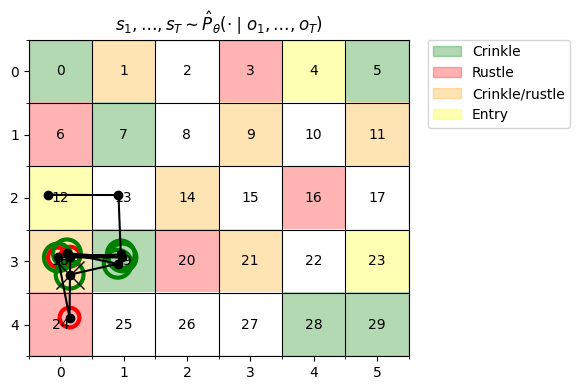

In [26]:
agent = Agent(env)
P_joint = agent.P_trajectories(predicted_observations.astype(int))


probs = list(P_joint.values())
print(sum(probs))
assert abs(sum(probs) - 1) <= 0.05

possible_paths = [np.fromstring(k, sep=' ') for k in P_joint.keys()] 
sample_indices = np.random.choice(len(probs), size=10, p=probs)
trajectories = [possible_paths[i].astype(int) for i in sample_indices]

# Visualise
fig, ax = env.render(
    trajectories[0],
    predicted_observations,
    title=r"$s_1,\ldots,s_T \sim \hat P_\theta(\cdot \mid o_1,\ldots,o_T)$"
)
plt.show()

## Part V. `TinyTransformerDecoderDoubleHead`, Shared Representation

### Theory

Notice that both the previous tasks (imitation learning and model learning) have something in common; namely the input. It suggests it may be more efficient to share a representation in a deep architecture, rather than reimplementing both as separate networks. Such architectures will also be very useful later for reinforcement learning. 

Have a look at the architecture defined in the following. 

In [29]:
class TinyTransformerDecoderDoubleHead(nn.Module):
    def __init__(
            self,
            input_dim: int,
            act_dim: int,
            obs_dim: int,
            embedding_dim: int = 16,
            num_layers: int = 1,
            num_heads: int = 1,
            max_seq_len: int = 500
        ):
        super(TinyTransformerDecoderDoubleHead, self).__init__()

        self.input_projection = nn.Linear(
            input_dim, embedding_dim
        )

        self.positional_encoding = self._generate_positional_encoding(
            max_seq_len, embedding_dim
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model = embedding_dim,
            nhead = num_heads,
            dim_feedforward = 2 * embedding_dim,
            dropout = 0.0,
            batch_first = True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        self.act_projection = nn.Linear(embedding_dim, act_dim)
        self.obs_projection = nn.Linear(embedding_dim, obs_dim)


    def _generate_positional_encoding(self, max_seq_len: int, embedding_dim: int) -> torch.Tensor:
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim)
        )
        pos_encoding = torch.zeros(max_seq_len, embedding_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)

        return pos_encoding  # Shape: (max_seq_len, embedding_dim)


    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x_emb = self.input_projection(x)

        # Add positional encoding
        pos_encoding = self.positional_encoding[:x.size(1), :].to(x.device)
        x_emb = x_emb + pos_encoding

        # Generate causal mask
        causal_mask = nn.Transformer.generate_square_subsequent_mask(x.size(1))

        # Use mask in the encoder
        x_transformed = self.transformer(x_emb, mask=causal_mask)

        act = self.act_projection(x_transformed)
        obs = self.obs_projection(x_transformed)
        return act, obs

#### Question

Implement the Architecture in PyTorch using a double head (and shared inner representations). 

#### Answer

In [30]:
from torch.utils.data import Dataset, DataLoader


class TrajectoryDataset(Dataset):
    def __init__(self, env, N: int = 1000, T: int = 5):
        self.data = [generate_trajectory(env, T) for _ in range(N)]
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        observations, states = self.data[index]

        available_observations = observations[:-1]

        target_observations = observations[1:]
        target_states = states[1:]

        return torch.tensor(available_observations, dtype=torch.float32), \
               torch.tensor(target_observations, dtype=torch.float32), \
               torch.tensor(target_states, dtype=torch.long)


def generate_dual_data(N: int = 1000, T: int = 5, batch_size: int = 32):
    """
    Generate Dual Model Learning data.

    Parameters:
    -----------
        N (int, optional): number of examples on the dataset. Default is '1000'.
        T (int, optional): number of observations per example. Default is '6'.
        batch_size (int, optional) : data batch size. Default is '32'.
    """
    return DataLoader(
        TrajectoryDataset(env, N=N, T=T), batch_size=batch_size, shuffle=True
    )

In [33]:
# TASK 4 SHARED REPRESENTATION

train_dataloader = generate_dual_data()


# Model Initialization
model = TinyTransformerDecoderDoubleHead(
    input_dim = 2,
    act_dim = 2,
    obs_dim = 30,
    embedding_dim = 64,
    num_layers = 3,
    num_heads = 4,
)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(50):
    for observed_batch, observation_target, state_target in train_dataloader:
        
        observation_prediction, state_prediction = model(observed_batch)

        optimizer.zero_grad()
        loss_observation = torch.nn.functional.mse_loss(
            observation_prediction, observation_target
        )
        loss_state = torch.nn.functional.cross_entropy(
            state_prediction.view(-1, 30), state_target.view(-1)
        )
        loss = loss_observation + loss_state
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1:02d}, Loss: {loss.item()}")

Epoch 01, Loss: 3.4540092945098877
Epoch 02, Loss: 3.2407491207122803
Epoch 03, Loss: 2.9779398441314697
Epoch 04, Loss: 2.85971736907959
Epoch 05, Loss: 2.582979679107666
Epoch 06, Loss: 2.362941265106201
Epoch 07, Loss: 2.5055768489837646
Epoch 08, Loss: 2.486603260040283
Epoch 09, Loss: 2.297267436981201
Epoch 10, Loss: 2.385561227798462
Epoch 11, Loss: 2.173128843307495
Epoch 12, Loss: 2.392397165298462
Epoch 13, Loss: 2.2108607292175293
Epoch 14, Loss: 2.1676580905914307
Epoch 15, Loss: 2.163067102432251
Epoch 16, Loss: 2.33670711517334
Epoch 17, Loss: 2.372889757156372
Epoch 18, Loss: 2.1195147037506104
Epoch 19, Loss: 2.320737361907959
Epoch 20, Loss: 2.545332431793213
Epoch 21, Loss: 2.126425266265869
Epoch 22, Loss: 2.279984474182129
Epoch 23, Loss: 2.4289138317108154
Epoch 24, Loss: 2.132672071456909
Epoch 25, Loss: 2.157898187637329
Epoch 26, Loss: 2.149275541305542
Epoch 27, Loss: 2.533148765563965
Epoch 28, Loss: 2.1144917011260986
Epoch 29, Loss: 2.340878963470459
Epoch 3

In [37]:
model.eval()
with torch.no_grad():
    observations, state = generate_trajectory(env, 5)
    observations_tensor = torch.tensor(observations[:-1], dtype=torch.float32).unsqueeze(0)
    
    observation_prediction, state_prediction = model(observations_tensor)

    observation_prediction = observation_prediction.squeeze(0).cpu().numpy()
    state_prediction = state_prediction.argmax(dim=-1).squeeze(0).cpu().numpy()

    print("Observations:", observations[1:])
    print("States:", state[1:])
    print()
    print("Observations Prediction:", observation_prediction.round())
    print("States Predicted:", state_prediction)

Observations: [[0 1]
 [0 0]
 [0 1]
 [0 0]]
States: [5 4 5 4]

Observations Prediction: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
States Predicted: [18 11 10 23]
